In [1]:
import json
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import time, datetime, math
import seaborn as sns
%matplotlib notebook

#DATA_DIR = 'data/twitter/predicted/'
DATA_DIR = 'data/tweets/btc_final/'
SAVE_TO = 'data/twitter/sentiment/'

def print_time(unix, str=''):
    print(str, time.ctime(int(unix)))
    
def get_readable_time(unix):
    return [time.ctime(int(u)) for u in unix]

def timestamp_round(timestamp, r = 300):
    return math.floor((timestamp)/r)*r

def expand_missing_data(dataframe):
    dataframe.sort_values(by='date').reset_index()
    start_date = min(dataframe['date'])
    end_date = max(dataframe['date'])
    print_time(start_date, 'Start Date:')
    print_time(end_date, 'End Date:')
    interval = math.floor((end_date - start_date)/300)
    #time_diff = dataframe['date'].diff().reset_index().sort_values(by='date', ascending=False)[1:]
    
    dataframe['round_interval'] = False
    for row in dataframe.itertuples():
        if row[2]%300 == 0: #row[2] is date 
            dataframe.set_value(row[0], 'round_interval', True) #row[0] is index of the row
            #pass
            
    interpolated = pd.DataFrame(index=range(0,interval),columns=list(dataframe.columns.values))
    interpolated['round_interval'] = True
    start_date = timestamp_round(start_date)
    end_date = timestamp_round(end_date)
    #print(start_date, end_date, interval)
    interpolated['date'] = pd.Series(np.arange(start_date,end_date,300))
    
    interpolated = interpolated.reset_index(drop=True)

    dff = pd.concat([dataframe, interpolated], axis=0).sort_values(by='date').reset_index(drop=True)
    del dff['currency']
    dff[['favorites']] = dff[['favorites']].astype(float)
    dff = dff.interpolate(method='linear', axis=0)
    dff = dff[~dff.duplicated()]
    dff = dff[~dff['date'].duplicated()]
    dff = dff[1:].query('round_interval')
    del dff['round_interval']
    return dff
    #dff = dff[~dff['date'].duplicated()]
    #print(dff.duplicated(keep=False))

In [20]:
twitter_df = pd.DataFrame()
for filename in os.listdir(DATA_DIR):
    content = pd.read_csv(DATA_DIR + filename, sep='\t')
    twitter_df = pd.concat([twitter_df, content])

print(twitter_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47389 entries, 0 to 0
Data columns (total 15 columns):
currency       47389 non-null object
tweet          47389 non-null object
username       47389 non-null object
favorites      47389 non-null int64
retweets       47389 non-null int64
date           47389 non-null int64
id             47389 non-null int64
permalink      47389 non-null object
geo            0 non-null float64
hashtags       21310 non-null object
mentions       13811 non-null object
lex_sent       47389 non-null float64
vader_sent     47389 non-null float64
cnn_sent       47389 non-null float64
cnn_pos_neg    47389 non-null float64
dtypes: float64(5), int64(4), object(6)
memory usage: 5.8+ MB
None


In [42]:
twitter_df = twitter_df.reset_index()
fields = ['currency', 'date', 'vader_sent', 'favorites', 'lex_sent', 'cnn_sent', 'cnn_pos_neg']
#remove entries where we don't have currency
twitter_df = twitter_df[pd.notnull(twitter_df['currency'])]
#fill NaN values with zeros in lex_sent column
twitter_df['lex_sent'] = twitter_df['lex_sent'].fillna(0)
#twitter_df[fields].sort_values(by='date', ascending=True).query('favorites>1')

#filter only specific currency
btc_df = twitter_df[twitter_df.currency.str.contains('bitcoin')]
btc_df = btc_df.reset_index(drop=True)
btc_df['currency'] = 'btc'
btc_df[fields].to_pickle(SAVE_TO + 'BTC_SENTIMENT.pkl')

ltc_df = twitter_df[twitter_df.currency.str.contains('litecoin')]
ltc_df = ltc_df.reset_index(drop=True)
ltc_df['currency'] = 'ltc'
ltc_df[fields].to_pickle(SAVE_TO + 'LTC_SENTIMENT.pkl')

eth_df = twitter_df[twitter_df.currency.str.contains('ethereum')]
eth_df = eth_df.reset_index(drop=True)
eth_df['currency'] = 'eth'
eth_df[fields].to_pickle(SAVE_TO + 'ETH_SENTIMENT.pkl')

xrp_df = twitter_df[twitter_df.currency.str.contains('ripple')]
xrp_df = xrp_df.reset_index(drop=True)
xrp_df['currency'] = 'xrp'
xrp_df[fields].to_pickle(SAVE_TO + 'XRP_SENTIMENT.pkl')


In [2]:
btc_df = pd.read_pickle(SAVE_TO + 'BTC_SENTIMENT.pkl')
ltc_df = pd.read_pickle(SAVE_TO + 'LTC_SENTIMENT.pkl')
eth_df = pd.read_pickle(SAVE_TO + 'ETH_SENTIMENT.pkl')
xrp_df = pd.read_pickle(SAVE_TO + 'XRP_SENTIMENT.pkl')
sentiment_df = pd.concat([btc_df, ltc_df, eth_df, xrp_df])
sentiment_df = pd.concat([sentiment_df, pd.get_dummies(sentiment_df['currency'])], axis=1)
del sentiment_df['currency']
#sentiment_df = sentiment_df.add_prefix('sentiment_')
sentiment_df = sentiment_df.sort_values(by='date').reset_index()
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50230 entries, 0 to 50229
Data columns (total 11 columns):
index          50230 non-null int64
date           50230 non-null int64
vader_sent     50230 non-null float64
favorites      50230 non-null int64
lex_sent       50230 non-null float64
cnn_sent       50230 non-null float64
cnn_pos_neg    50230 non-null float64
btc            50230 non-null uint8
eth            50230 non-null uint8
ltc            50230 non-null uint8
xrp            50230 non-null uint8
dtypes: float64(4), int64(3), uint8(4)
memory usage: 2.9 MB


In [41]:
np.mean(btc_df['cnn_pos_neg'])

0.13444048196838929

In [4]:
expanded = expand_missing_data(btc_df)
expanded.to_pickle(SAVE_TO + 'btc_expanded.pkl')
expanded.info()

Start Date: Fri Jan  1 01:50:14 2016
End Date: Sun Apr  1 00:49:00 2018


c:\users\deyan\tf-workspace\env\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


<class 'pandas.core.frame.DataFrame'>
Int64Index: 236422 entries, 2 to 283810
Data columns (total 6 columns):
date           236422 non-null int64
vader_sent     236422 non-null float64
favorites      236422 non-null float64
lex_sent       236422 non-null float64
cnn_sent       236422 non-null float64
cnn_pos_neg    236422 non-null float64
dtypes: float64(5), int64(1)
memory usage: 12.6 MB


In [3]:
expanded = expand_missing_data(ltc_df)
expanded.to_pickle(SAVE_TO + 'ltc_expanded.pkl')
expanded.info()

Start Date: Fri Jan  8 01:30:55 2016
End Date: Fri Mar 30 08:39:57 2018


c:\users\deyan\tf-workspace\env\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


<class 'pandas.core.frame.DataFrame'>
Int64Index: 233928 entries, 2 to 234481
Data columns (total 6 columns):
date           233928 non-null int64
vader_sent     233928 non-null float64
favorites      233928 non-null float64
lex_sent       233928 non-null float64
cnn_sent       233928 non-null float64
cnn_pos_neg    233928 non-null float64
dtypes: float64(5), int64(1)
memory usage: 12.5 MB


In [4]:
expanded = expand_missing_data(eth_df)
expanded.to_pickle(SAVE_TO + 'eth_expanded.pkl')
expanded.info()

Start Date: Wed Jan  6 20:18:56 2016
End Date: Sat Mar 31 00:49:01 2018


c:\users\deyan\tf-workspace\env\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


<class 'pandas.core.frame.DataFrame'>
Int64Index: 234473 entries, 2 to 236309
Data columns (total 6 columns):
date           234473 non-null int64
vader_sent     234473 non-null float64
favorites      234473 non-null float64
lex_sent       234473 non-null float64
cnn_sent       234473 non-null float64
cnn_pos_neg    234473 non-null float64
dtypes: float64(5), int64(1)
memory usage: 12.5 MB


In [5]:
expanded = expand_missing_data(xrp_df)
expanded.to_pickle(SAVE_TO + 'xrp_expanded.pkl')
expanded.info()

Start Date: Wed Jan 13 10:06:54 2016
End Date: Sat Mar 31 19:57:45 2018


c:\users\deyan\tf-workspace\env\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


<class 'pandas.core.frame.DataFrame'>
Int64Index: 232809 entries, 2 to 233258
Data columns (total 6 columns):
date           232809 non-null int64
vader_sent     232809 non-null float64
favorites      232809 non-null float64
lex_sent       232809 non-null float64
cnn_sent       232809 non-null float64
cnn_pos_neg    232809 non-null float64
dtypes: float64(5), int64(1)
memory usage: 12.4 MB


In [146]:
expanded.describe()
#expanded[expanded['date'].duplicated(keep=False)]

,vader_sent,favorites,lex_sent
count,227214.000000,227214.000000,227214.000000
mean,0.080054,51.125926,0.195951
std,0.293222,326.739222,0.237592
min,-4.109505,-1173.626877,-2.734677
25%,-0.031254,2.786228,0.034333
50%,0.028356,9.585586,0.187540
75%,0.219222,31.964225,0.324576
max,3.989306,86330.164849,3.900430


In [43]:
start_date = min(sentiment_df['date'])
end_date = max(sentiment_df['date'])
interval = math.floor(max(sentiment_df['date']) - min(sentiment_df['date']))
time_diff = sentiment_df['date'].diff().reset_index().sort_values(by='date', ascending=False)[1:]


print(20*'#')
count = 0
sentiment_df['round_interval'] = False
for row in sentiment_df.itertuples():
    if row[2]%300 == 0:
        #print(row[2])
        sentiment_df.set_value(row[0], 'round_interval', True)
        count += 1

###


interpolated = pd.DataFrame(index=range(0,interval),columns=list(sentiment_df.columns.values))
interpolated['round_interval'] = True
start_date = timestamp_round(start_date)

#set date
for i, row in interpolated.iterrows():
    interpolated.set_value(i, 'date', start_date)
    start_date += 300
    
interpolated = interpolated.reset_index(drop=True)
interpolated.info()

sentiment_df = sentiment_df.reset_index(drop=True).drop(columns=['index'])
interpolated = interpolated.reset_index(drop=True).drop(columns=['index'])

dff = pd.concat([sentiment_df, interpolated]).sort_values(by='date').reset_index(drop=True)
dff[['btc', 'eth', 'ltc', 'xrp', 'favorites']] = dff[['btc', 'eth', 'ltc', 'xrp', 'favorites']].astype(float)
dff = dff.interpolate(method='akima', axis=0)
#dff = dff[~dff['date'].duplicated()]
#print(dff.duplicated(keep=False))

####################


c:\users\deyan\tf-workspace\env\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]


TypeError: 'int' object is not iterable

In [4]:
print(dff[dff['date'].duplicated(keep=False)])

Empty DataFrame
Columns: [date, vader_sent, favorites, lex_sent, btc, eth, ltc, xrp, round_interval]
Index: []


In [70]:
t = pd.DataFrame({
    'btc': [1,0,0,0,np.NaN,1],
    'ltc': [1,0,0,np.NaN,np.NaN,1],
    'vader_sent': [-1,np.NaN,np.NaN,np.NaN,np.NaN,4.3],
})
t = t.interpolate(method='akima', axis=0)
t['num'] = pd.Series(np.arange(0,50,5))

In [150]:
t['num'] = pd.Series(np.arange(10,50,5))
t.query('15<num<30')

,btc,ltc,vader_sent,num,date
2,0.0,0.000000,-0.044,20,1451610000
3,0.0,0.259259,1.016,25,1451610300


In [220]:
sentiment_df = sentiment_df.reset_index(drop=True).drop(columns=['index'])
interpolated = interpolated.reset_index(drop=True).drop(columns=['index'])

dff = pd.concat([sentiment_df, interpolated]).sort_values(by='date').reset_index(drop=True)
dff[['btc', 'eth', 'ltc', 'xrp', 'favorites']] = dff[['btc', 'eth', 'ltc', 'xrp', 'favorites']].astype(float)
dff = dff.interpolate(method='akima', axis=0)
#print(dff.duplicated(keep=False))

ValueError: labels ['index'] not contained in axis

In [30]:
dff1 = sentiment_df[900:]
dff2 = interpolated[900:]

dff1['round_interval'] = False

#dff1 = dff1.reset_index(drop=True).drop(columns=['index'])
#dff2 = dff2.reset_index(drop=True).drop(columns=['index'])

#print(dff1)
#print(dff2)

dff = pd.concat([dff1, dff2]).sort_values(by='date').reset_index(drop=True)
dff[['btc', 'eth', 'ltc', 'xrp', 'favorites']] = dff[['btc', 'eth', 'ltc', 'xrp', 'favorites']].astype(float)
dff.drop(columns=['favorites'], inplace=True)
dff = dff.interpolate(method='akima', axis=0)

print(dff[dff['date'].duplicated(keep=False)].sort_values(by='date'))
#print(dff)
#print(dff.info())

c:\users\deyan\tf-workspace\env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


              date  vader_sent  lex_sent  btc  eth  ltc  xrp  round_interval
3877    1453041118     -0.6908     -0.07  0.0  1.0  0.0  0.0           False
3878    1453041118     -0.6908     -0.07  1.0  0.0  0.0  0.0           False
4239    1453131983     -0.6249      0.15  0.0  1.0  0.0  0.0           False
4240    1453131983     -0.6249      0.15  1.0  0.0  0.0  0.0           False
4313    1453149334      0.5423      0.15  0.0  1.0  0.0  0.0           False
4314    1453149334      0.5423      0.15  1.0  0.0  0.0  0.0           False
4348    1453157917      0.5106      0.46  0.0  0.0  1.0  0.0           False
4349    1453157917      0.5106      0.46  0.0  1.0  0.0  0.0           False
4939    1453304101      0.0000     -0.12  1.0  0.0  0.0  0.0           False
4940    1453304101      0.0000     -0.12  0.0  0.0  0.0  1.0           False
5975    1453562898      0.0000      0.29  0.0  0.0  1.0  0.0           False
5974    1453562898      0.0000      0.29  0.0  1.0  0.0  0.0           False

In [36]:
dff[dff['date'].duplicated(keep=False)]

,date,vader_sent,lex_sent,btc,eth,ltc,xrp,round_interval
3877,1453041118,-0.6908,-0.07,0.0,1.0,0.0,0.0,False
3878,1453041118,-0.6908,-0.07,1.0,0.0,0.0,0.0,False
4239,1453131983,-0.6249,0.15,0.0,1.0,0.0,0.0,False
4240,1453131983,-0.6249,0.15,1.0,0.0,0.0,0.0,False
4313,1453149334,0.5423,0.15,0.0,1.0,0.0,0.0,False
4314,1453149334,0.5423,0.15,1.0,0.0,0.0,0.0,False
4348,1453157917,0.5106,0.46,0.0,0.0,1.0,0.0,False
4349,1453157917,0.5106,0.46,0.0,1.0,0.0,0.0,False
4939,1453304101,0.0000,-0.12,1.0,0.0,0.0,0.0,False
4940,1453304101,0.0000,-0.12,0.0,0.0,0.0,1.0,False


In [35]:
diff_one_hot = print(dff[dff['date'].duplicated(keep=False)].sort_values(by='date')[['btc', 'ltc', 'eth', 'xrp']].diff()[1:])

        btc  ltc  eth  xrp
3878    1.0  0.0 -1.0  0.0
4239   -1.0  0.0  1.0  0.0
4240    1.0  0.0 -1.0  0.0
4313   -1.0  0.0  1.0  0.0
4314    1.0  0.0 -1.0  0.0
4348   -1.0  1.0  0.0  0.0
4349    0.0 -1.0  1.0  0.0
4939    1.0  0.0 -1.0  0.0
4940   -1.0  0.0  0.0  1.0
5975    0.0  1.0  0.0 -1.0
5974    0.0 -1.0  1.0  0.0
6293    0.0  1.0 -1.0  0.0
6294    1.0 -1.0  0.0  0.0
6329    0.0  0.0  0.0  0.0
6330   -1.0  1.0  0.0  0.0
6331    0.0 -1.0  1.0  0.0
6335    1.0  0.0 -1.0  0.0
6336   -1.0  0.0  1.0  0.0
6350    0.0  1.0 -1.0  0.0
6348    1.0 -1.0  0.0  0.0
6349   -1.0  0.0  1.0  0.0
6608    0.0  0.0  0.0  0.0
6607    0.0  1.0 -1.0  0.0
6993    1.0 -1.0  0.0  0.0
6994   -1.0  0.0  1.0  0.0
6995    0.0  0.0  0.0  0.0
6996    0.0  1.0 -1.0  0.0
6997    1.0 -1.0  0.0  0.0
7022   -1.0  0.0  0.0  1.0
7023    0.5  0.0  0.0 -0.5
...     ...  ...  ...  ...
279890  1.0  0.0 -1.0  0.0
280170  0.0  0.0  0.0  0.0
280171 -1.0  0.0  1.0  0.0
280196  1.0  0.0 -1.0  0.0
280195 -1.0  0.0  1.0  0.0
2

In [135]:
#sentiment_df
#new = pd.merge_ordered(interpolated, sentiment_df, fill_method='ffill', left_by='date')
new = pd.concat([interpolated, sentiment_df])
new

KeyboardInterrupt: 

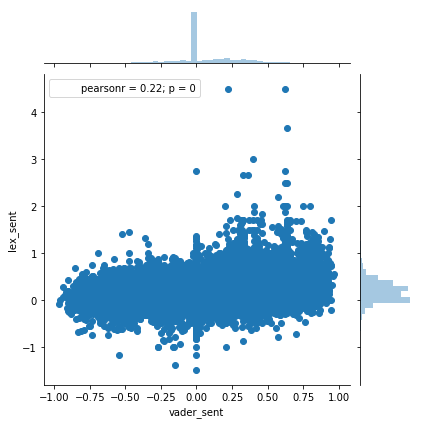

In [10]:
sns.jointplot(x="vader_sent", y="lex_sent", data=btc_df)

-0.9658


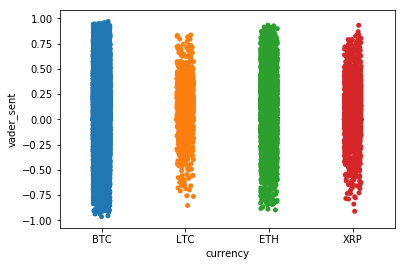

In [11]:
sns.stripplot(y="vader_sent", x="currency", data=sentiment_df, jitter=True);

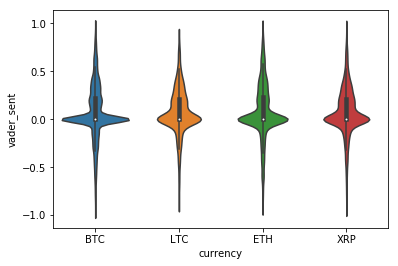

In [17]:
sns.violinplot(y="vader_sent", x="currency", data=sentiment_df);

In [102]:
dates = get_readable_time(list(twitter_df['date']))
time_diff = twitter_df['date'].diff().sort_values(ascending=False)
time_diff.describe()

count     53623
unique    33125
top         -85
freq         41
Name: date, dtype: int64